# Drift Detection Methods for One Variable 

In [1]:
import pandas as pd
import numpy as np
import random
import string
import scipy.optimize as opt
import seaborn as sns

In [2]:
time_a_df = pd.read_csv(r'c:\Users\Danny\Desktop\Drift Detection\Working File\CSV\time_a_df.csv')
time_b_df = pd.read_csv(r'c:\Users\Danny\Desktop\Drift Detection\Working File\CSV\time_b_df.csv')

In [3]:
time_a_df.head()

,Unnamed: 0,Date,CTR,CTR Group,Drop-Off Rate,Drop-Off Group,Engagement Time (minutes),Likes Given,Likes Group,Shares,Shares Group,Comments Written,Comments Group,UserID,Group
0,0,2024-01-01,0.027494,Standard Users,0.059013,Baseline,44.234646,0.039999,Baseline,0.007880,Drifters,0.009989,Baseline,WJUY3731,Baseline
1,1,2024-01-02,0.027244,Standard Users,0.054182,Baseline,38.941909,0.057157,Baseline,0.051965,Drifters,0.015926,Baseline,WJUY3731,Baseline
2,2,2024-01-03,0.026581,Standard Users,0.051842,Baseline,46.183249,0.045900,Baseline,0.000000,Drifters,0.007913,Baseline,WJUY3731,Baseline
3,3,2024-01-04,0.026986,Standard Users,0.035344,Baseline,43.095455,0.009572,Baseline,0.010601,Drifters,0.016023,Baseline,WJUY3731,Baseline
4,4,2024-01-05,0.027342,Standard Users,0.058600,Baseline,50.404296,0.054061,Baseline,0.028740,Drifters,0.011335,Baseline,WJUY3731,Baseline


In [4]:
time_b_df.head()

,Unnamed: 0,Date,CTR,CTR Group,Drop-Off Rate,Drop-Off Group,Engagement Time (minutes),Likes Given,Likes Group,Shares,Shares Group,Comments Written,Comments Group,UserID,Group,15-Day Interval
0,0,2024-01-01,0.035483,Standard Users,0.079901,Baseline,49.519855,0.118284,Power Users,0.060250,Power Users,0.019898,Baseline,AFWR7047,Baseline,0
1,1,2024-01-02,0.027044,Standard Users,0.063724,Baseline,31.483928,0.156275,Power Users,0.060184,Power Users,0.015578,Baseline,AFWR7047,Baseline,0
2,2,2024-01-03,0.031278,Standard Users,0.060870,Baseline,38.949874,0.112235,Power Users,0.095071,Power Users,0.009765,Baseline,AFWR7047,Baseline,0
3,3,2024-01-04,0.035901,Standard Users,0.050745,Baseline,32.128908,0.157594,Power Users,0.057522,Power Users,0.017707,Baseline,AFWR7047,Baseline,0
4,4,2024-01-05,0.040242,Standard Users,0.065317,Baseline,38.688656,0.149799,Power Users,0.055905,Power Users,0.014013,Baseline,AFWR7047,Baseline,0


In [5]:
from scipy.stats import ks_2samp
import pandas as pd

# Sort Time B by Date to ensure proper ordering
time_b_df["Date"] = pd.to_datetime(time_b_df["Date"])
time_b_df = time_b_df.sort_values("Date")

# Group Time B data by date
grouped_time_b = time_b_df.groupby("Date")["Engagement Time (minutes)"]

# Initialize results
significance_level = 0.05
drift_detected_day = None
results = []

# Iterate through each date in Time B
for day_index, (current_date, engagement_times) in enumerate(grouped_time_b):
    # Take cumulative data up to the current day
    cumulative_time_b = time_b_df[time_b_df["Date"] <= current_date]["Engagement Time (minutes)"]

    # Perform KS Test between Time A and cumulative Time B
    ks_stat, p_value = ks_2samp(time_a_df["Engagement Time (minutes)"], cumulative_time_b)

    # Append results for this day
    results.append({"Date": current_date, "Day Index": day_index + 1, "KS Statistic": ks_stat, "P-Value": p_value})

    # Check if drift is detected
    if p_value < significance_level and drift_detected_day is None:
        drift_detected_day = current_date
        print(f"Drift detected on {current_date} (Day {day_index + 1})")
        break  # Stop the loop if drift is detected

# Save results to a DataFrame
results_df = pd.DataFrame(results)
results_df

Drift detected on 2024-01-08 00:00:00 (Day 8)


,Date,Day Index,KS Statistic,P-Value
0,2024-01-01,1,0.047611,0.970468
1,2024-01-02,2,0.054333,0.583564
2,2024-01-03,3,0.056667,0.288768
3,2024-01-04,4,0.054333,0.191529
4,2024-01-05,5,0.048333,0.199704
5,2024-01-06,6,0.048333,0.128185
6,2024-01-07,7,0.050952,0.058348
7,2024-01-08,8,0.051917,0.031054


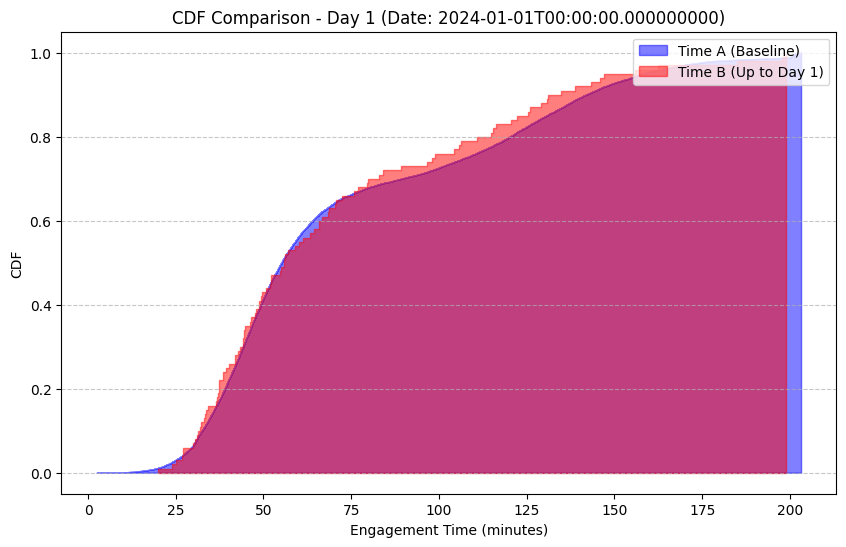

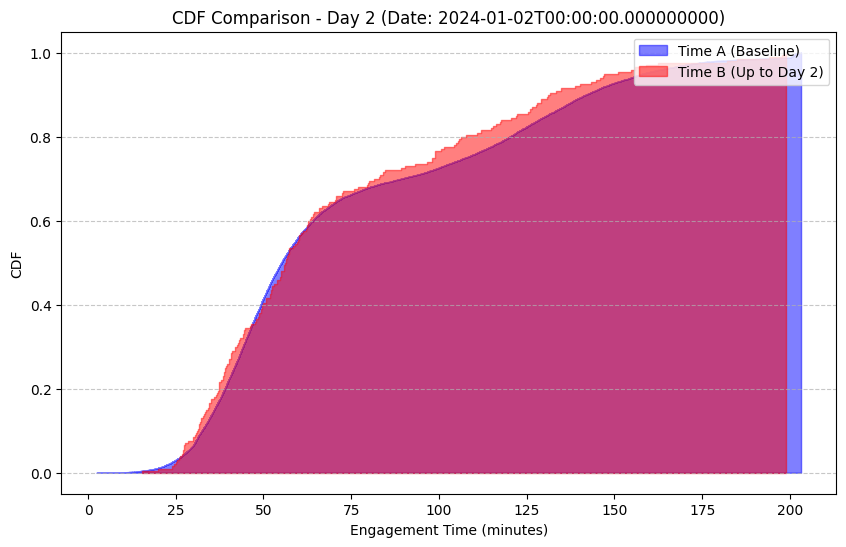

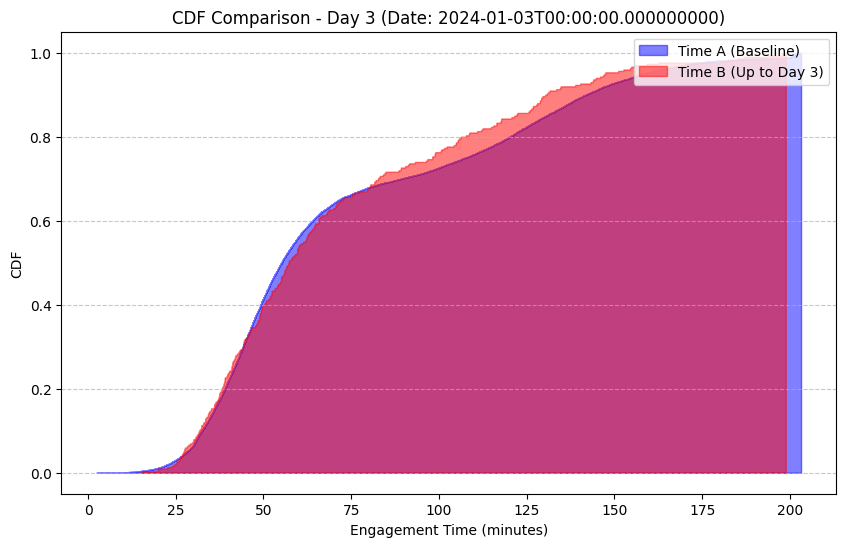

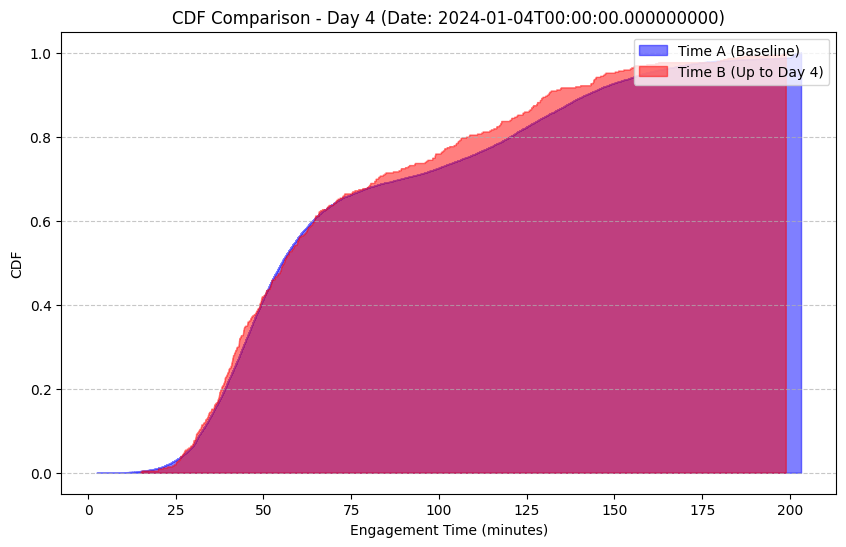

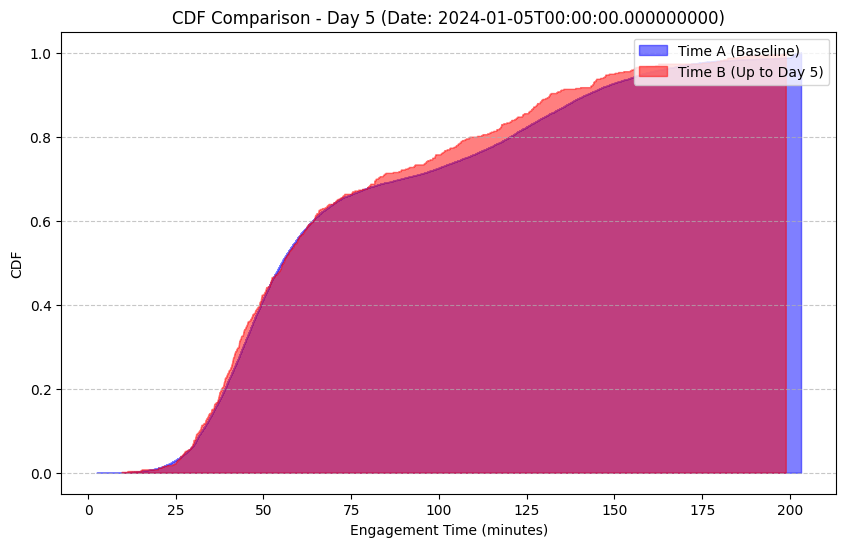

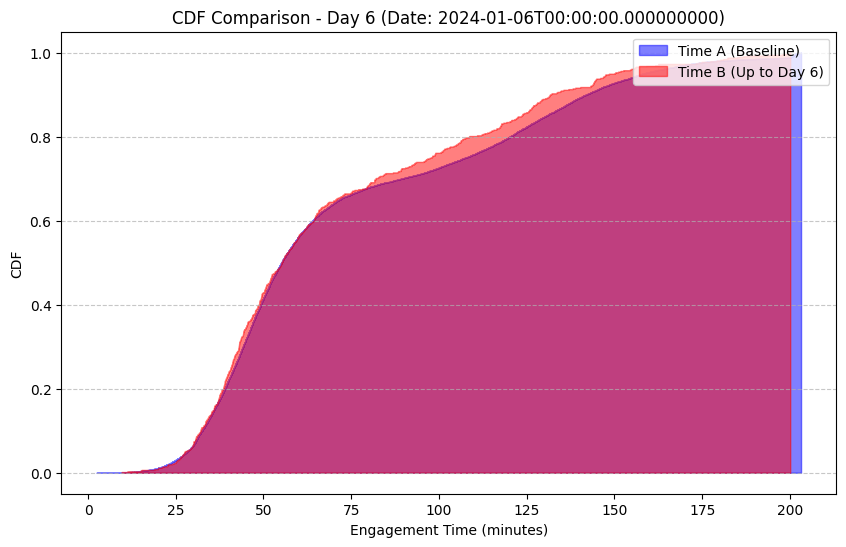

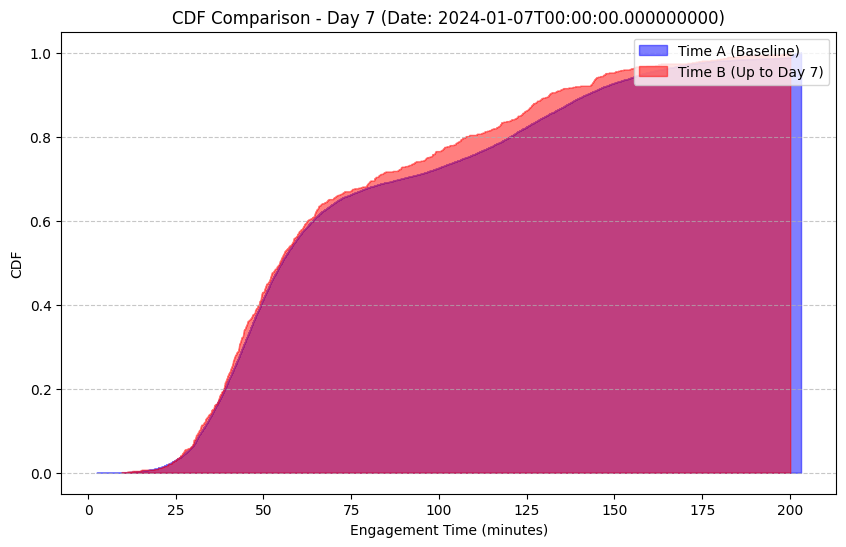

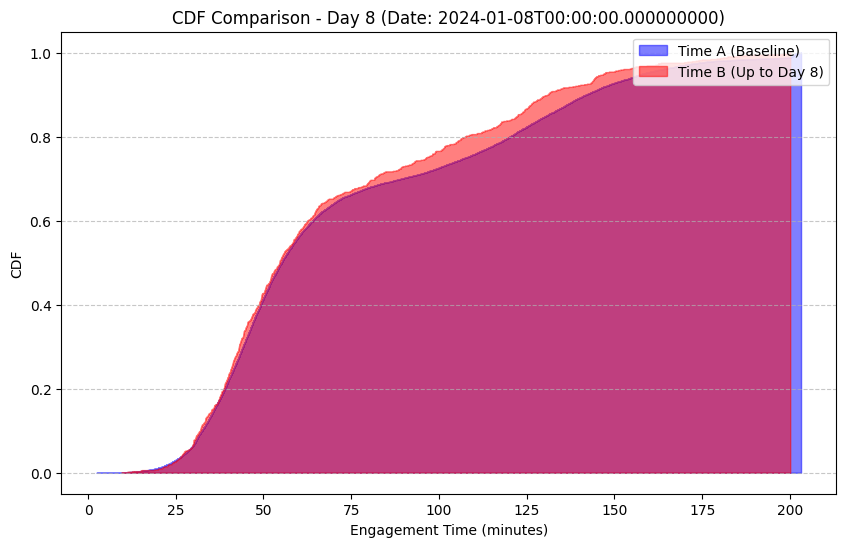

In [6]:
import matplotlib.pyplot as plt

# Function to plot CDFs for each day up to the drift detection point
def plot_cdfs_by_day(results_df, time_a, time_b):
    drift_day = results_df[results_df["Drift Detected"]].iloc[0]["Day Index"] if "Drift Detected" in results_df else len(results_df)

    # Iterate through days up to drift detection day
    for day in range(1, drift_day + 1):
        current_date = results_df[results_df["Day Index"] == day]["Date"].values[0]
        cumulative_time_b = time_b[time_b["Date"] <= current_date]["Engagement Time (minutes)"]

        # Compute the CDFs
        sorted_a = np.sort(time_a)
        sorted_b = np.sort(cumulative_time_b)
        cdf_a = np.arange(1, len(sorted_a) + 1) / len(sorted_a)
        cdf_b = np.arange(1, len(sorted_b) + 1) / len(sorted_b)

        # Plot CDFs
        plt.figure(figsize=(10, 6))
        plt.fill_between(sorted_a, 0, cdf_a, alpha=0.5, label="Time A (Baseline)", color="blue", step="post")
        plt.fill_between(sorted_b, 0, cdf_b, alpha=0.5, label=f"Time B (Up to Day {day})", color="red", step="post")
        plt.title(f"CDF Comparison - Day {day} (Date: {current_date})")
        plt.xlabel("Engagement Time (minutes)")
        plt.ylabel("CDF")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

# Run the plotting function
plot_cdfs_by_day(results_df, time_a_df["Engagement Time (minutes)"], time_b_df)
